In [1]:
cbind(rbind(p, rej_rate), rbind('time', run_time))library(DRDRtest)

In [2]:
getwd()

[1] "/Users/yanyuchen/Documents/GitHub/causal_net_test"

In [4]:
load_dir = '/dataset/simu2/eval/0/'

In [39]:
load_dir = '/dataset/simu2/eval/0/'
dat = read.csv(paste(getwd(), load_dir, 'delta_0.5_data.txt', sep = ''), header = F, sep = ' ')
t_grid = read.csv(paste(getwd(), load_dir, 'delta_0.5_t_grid.txt', sep = ''), header = F, sep = ' ')
t_grid = as.data.frame(t(t_grid))
head(t_grid)

,V1,V2
,<dbl>,<dbl>
V1,0.11525252,1.862437e-07
V2,0.99464446,1.182905e-11
V3,0.45301449,4.009531e-01
V4,0.01059023,1.979999e-11
V5,0.77115458,3.205001e-04
V6,0.56185955,3.410223e-01


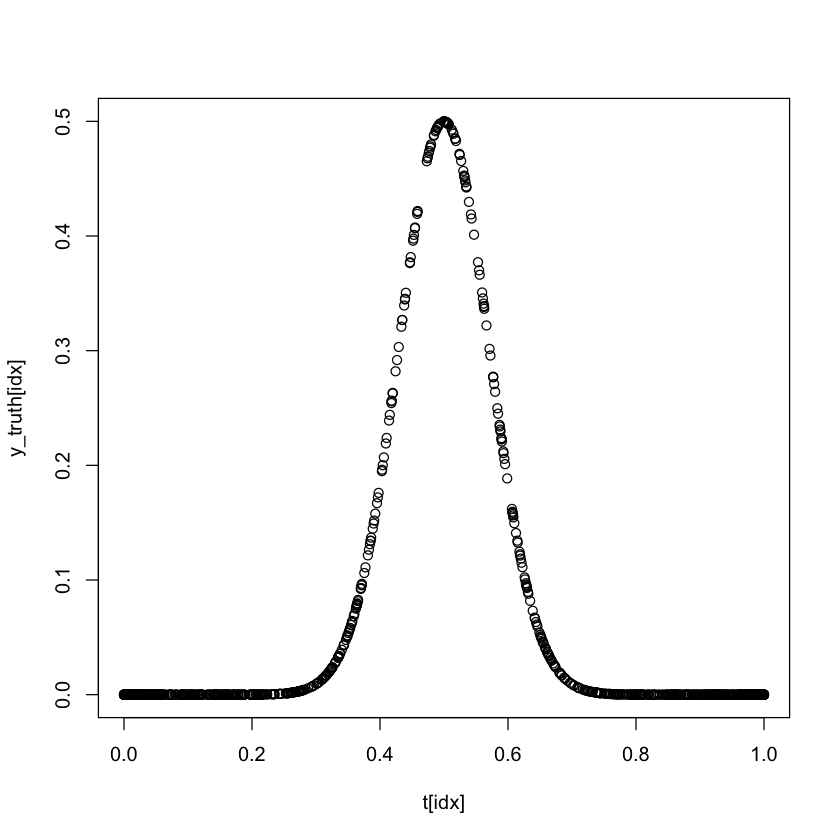

In [46]:
t = t_grid[[1]]
y_truth = t_grid[[2]]

idx = order(t)
plot(t[idx], y_truth[idx])

In [70]:
mu.mod<-function(a,l,delta){
mu <- as.numeric(l%*%c(0.2,0.2,0.3,-0.1))+triangle(a, delta)+a*(-0.1*l[,1]+0.1*l[,3])
return(mu) }

triangle <- function(a,delta){
    y <- exp(-100 * (a-0.5)^2)*delta
    return(y)
}

In [82]:
library(SuperLearner)
library(xgboost)

In [90]:
num = 200
n <- 1000
d <- 4
delta = 0.5

p_val = rep(0, num)
for (i in 1:num){
    l <- matrix(rnorm(n*d),ncol=d)
    colnames(l) <- paste("l",1:4,sep="")

    logit.lambda <- as.numeric(l%*%c(0.1,0.1,-0.1,0.2))
    lambda <- exp(logit.lambda)/(1+exp(logit.lambda))
    a <- rbeta(n, shape1 = lambda, shape2 =1-lambda)
    mu <- mu.mod(a,l,delta)
    residual.list <- rnorm(n,mean=0,sd=sigma)
    y <- mu+residual.list

    #idx = order(a)
    #plot(a[idx], triangle(a[idx], delta))

    out <- drdrtest.superlearner(y, a, l, c(0.01,0.99), pi.sl.lib=c("SL.xgboost"), mu.sl.lib=c("SL.xgboost"))
    p_val[i] = out$p.value
}
mean(p_val < 0.05)

[1] 1

In [91]:
num = 200
n <- 1000
d <- 4
delta = 0

p_val = rep(0, num)
for (i in 1:num){
    l <- matrix(rnorm(n*d),ncol=d)
    colnames(l) <- paste("l",1:4,sep="")

    logit.lambda <- as.numeric(l%*%c(0.1,0.1,-0.1,0.2))
    lambda <- exp(logit.lambda)/(1+exp(logit.lambda))
    a <- rbeta(n, shape1 = lambda, shape2 =1-lambda)
    mu <- mu.mod(a,l,delta)
    residual.list <- rnorm(n,mean=0,sd=sigma)
    y <- mu+residual.list

    #idx = order(a)
    #plot(a[idx], triangle(a[idx], delta))

    out <- drdrtest.superlearner(y, a, l, c(0.01,0.99), pi.sl.lib=c("SL.xgboost"), mu.sl.lib=c("SL.xgboost"))
    p_val[i] = out$p.value
}
# pi & mu
mean(p_val < 0.05)

[1] 0.995

In [ ]:
library(parallel)

num = 5
alpha = 0.05
delta_list = seq(0, 0.5, 0.1)
rej_rate = rep(0, length(delta_list))
cl <- makeCluster(detectCores())

save_dir = 'R/logs/simu2/eval/'
if (dir.exists(substr(save_dir, 1, 1)) == F){
    dir.create(substr(save_dir, 1, 1))
}
if (dir.exists(substr(save_dir, 1, 6)) == F){
    dir.create(substr(save_dir, 1, 6))
}
if (dir.exists(substr(save_dir, 1, 12)) == F){
    dir.create(substr(save_dir, 1, 12))
}
if (dir.exists(save_dir) == F){
    dir.create(save_dir)
}

idx = 1
for (delta in delta_list){
    f = function(i){
        library(DRDRtest)
        triangle <- function(a,delta){
            y <- exp(-100 * (a-0.5)^2)*delta
            return(y)
        }

        mu.mod <- function(a,l,delta){
            mu <- as.numeric(l%*%c(0.2,0.2,0.3,-0.1))+triangle(a, delta)+a*(-0.1*l[,1]+0.1*l[,3])
            return(mu)
        }

        pifunc <- function(a,l){
               l <- as.matrix(l)
               logit.lambda <- as.numeric(l%*%c(0.1,0.1,-0.1,0.2))
               lambda <- exp(logit.lambda)/(1+exp(logit.lambda))
               return(dbeta(a,shape1=lambda,shape2 = 1-lambda))
        }

        mufunc <- function(a,l){
           l <- as.matrix(l)
           return(mu.mod(a,l,delta))
        }

        load_dir = paste('/dataset/simu2/eval/', toString(i), '/', sep = '')
        dat = read.csv(paste(getwd(), load_dir, 'delta_', toString(delta), '_data.txt', sep = ''), header = F, sep = ' ')
        y = dat[[6]]
        a = dat[[1]]
        l = dat[2:5]
        out <- drdrtest(y, a, l, c(0.01,0.99), pifunc, mufunc)
        return(out$p.value)
    }
    
    f2 = function(i){
        library(DRDRtest)
        library(SuperLearner)
        library(earth)
        triangle <- function(a,delta){
            y <- exp(-100 * (a-0.5)^2)*delta
            return(y)
        }

        mu.mod <- function(a,l,delta){
            mu <- as.numeric(l%*%c(0.2,0.2,0.3,-0.1))+triangle(a, delta)+a*(-0.1*l[,1]+0.1*l[,3])
            return(mu)
        }

        pifunc <- function(a,l){
               l <- as.matrix(l)
               logit.lambda <- as.numeric(l%*%c(0.1,0.1,-0.1,0.2))
               lambda <- exp(logit.lambda)/(1+exp(logit.lambda))
               return(dbeta(a,shape1=lambda,shape2 = 1-lambda))
        }

        mufunc <- function(a,l){
           l <- as.matrix(l)
           return(mu.mod(a,l,delta))
        }

        load_dir = paste('/dataset/simu2/eval/', toString(i), '/', sep = '')
        dat = read.csv(paste(getwd(), load_dir, 'delta_', toString(delta), '_data.txt', sep = ''), header = F, sep = ' ')
        y = dat[[6]]
        a = dat[[1]]
        l = dat[2:5]
        # default algs: "SL.earth", "SL.glm", "SL.gam", "SL.glmnet"
        out <- drdrtest.superlearner(y, a, l, c(0.01,0.99))
        return(out$p.value)
    }
    clusterExport(cl, "delta")
    #out = parLapply(cl, 0:(num-1), f)
    out2 = parLapply(cl, 0:(num-1), f2)
    #rej_rate[idx] = mean(out < alpha)
    idx = idx + 1
    #write.table(out, file=paste(save_dir, "p_val_oracal_delta_", delta , '.txt', sep = ''), row.names=FALSE, col.names=FALSE)
    write.table(out2, file=paste(save_dir, "p_val_SuperLearner_delta_", delta , '.txt', sep = ''), row.names=FALSE, col.names=FALSE)
}

write.table(rbind(delta_list, rej_rate), file=paste(save_dir, 'SuperLearner_rej_rate.txt', sep = ''), row.names=FALSE, col.names=FALSE)

In [10]:
if (require(DRDRtest) == F){
  install.packages("DRDRtest")
}

if (require(SuperLearner) == F){
  install.packages("SuperLearner")
}

if (require(earth) == F){
  install.packages("earth")
}

library(parallel)

num = 2
delta_list = seq(0, 0.5, 0.1)
cl <- makeCluster(detectCores())

save_dir = 'R/logs/simu2/eval/'
if (dir.exists(substr(save_dir, 1, 1)) == F){
    dir.create(substr(save_dir, 1, 1))
}
if (dir.exists(substr(save_dir, 1, 6)) == F){
    dir.create(substr(save_dir, 1, 6))
}
if (dir.exists(substr(save_dir, 1, 12)) == F){
    dir.create(substr(save_dir, 1, 12))
}
if (dir.exists(save_dir) == F){
    dir.create(save_dir)
}

for (delta in delta_list){
    f = function(i){
        library(DRDRtest)
        triangle <- function(a,delta){
            y <- exp(-100 * (a-0.5)^2)*delta
            return(y)
        }

        mu.mod <- function(a,l,delta){
            mu <- as.numeric(l%*%c(0.2,0.2,0.3,-0.1))+triangle(a, delta)+a*(-0.1*l[,1]+0.1*l[,3])
            return(mu)
        }

        pifunc <- function(a,l){
               l <- as.matrix(l)
               logit.lambda <- as.numeric(l%*%c(0.1,0.1,-0.1,0.2))
               lambda <- exp(logit.lambda)/(1+exp(logit.lambda))
               return(dbeta(a,shape1=lambda,shape2 = 1-lambda))
        }

        mufunc <- function(a,l){
           l <- as.matrix(l)
           return(mu.mod(a,l,delta))
        }

        load_dir = paste('/dataset/simu2/eval/', toString(i), '/', sep = '')
        dat = read.csv(paste(getwd(), load_dir, 'delta_', toString(delta), '_data.txt', sep = ''), header = F, sep = ' ')
        y = dat[[6]]
        a = dat[[1]]
        l = dat[2:5]
        start_time <- Sys.time()
        out <- drdrtest(y, a, l, c(0.01,0.99), pifunc, mufunc, b = 200)
        end_time <- Sys.time()
        
        elapsed_time = end_time - start_time
        return(c(out$p.value, elapsed_time))
    }

    f2 = function(i){
        library(DRDRtest)
        library(SuperLearner)
        library(earth)
        triangle <- function(a,delta){
            y <- exp(-100 * (a-0.5)^2)*delta
            return(y)
        }

        mu.mod <- function(a,l,delta){
            mu <- as.numeric(l%*%c(0.2,0.2,0.3,-0.1))+triangle(a, delta)+a*(-0.1*l[,1]+0.1*l[,3])
            return(mu)
        }

        pifunc <- function(a,l){
               l <- as.matrix(l)
               logit.lambda <- as.numeric(l%*%c(0.1,0.1,-0.1,0.2))
               lambda <- exp(logit.lambda)/(1+exp(logit.lambda))
               return(dbeta(a,shape1=lambda,shape2 = 1-lambda))
        }

        mufunc <- function(a,l){
           l <- as.matrix(l)
           return(mu.mod(a,l,delta))
        }

        load_dir = paste('/dataset/simu2/eval/', toString(i), '/', sep = '')
        dat = read.csv(paste(getwd(), load_dir, 'delta_', toString(delta), '_data.txt', sep = ''), header = F, sep = ' ')
        y = dat[[6]]
        a = dat[[1]]
        l = dat[2:5]
        # default algs: "SL.earth", "SL.glm", "SL.gam", "SL.glmnet"
        start_time <- Sys.time()
        out <- drdrtest.superlearner(y, a, l, c(0.01,0.99), b = 200)
        end_time <- Sys.time()
        
        elapsed_time = end_time - start_time
        return(c(out$p.value, elapsed_time))
    }
    clusterExport(cl, "delta")
    out = parLapply(cl, 0:(num-1), f)
    out2 = parLapply(cl, 0:(num-1), f2)
    
    out = matrix(unlist(out), ncol = 2, byrow = TRUE)
    write.table(out[,1], file=paste(save_dir, "p_val_oracal_delta_", delta , '.txt', sep = ''), row.names=FALSE, col.names=FALSE)
    write.table(out[,2], file=paste(save_dir, "run_time_oracal_delta_", delta , '.txt', sep = ''), row.names=FALSE, col.names=FALSE)
    
    #write.table(out2, file=paste(save_dir, "p_val_SuperLearner_delta_", delta , '.txt', sep = ''), row.names=FALSE, col.names=FALSE)
}


alpha = 0.05
rej_rate = rep(0, length(delta_list))
rej_rate2 = rep(0, length(delta_list))

#idx = 1
#for (delta in delta_list){
#    out = read.csv(paste(save_dir, "p_val_oracal_delta_", delta , '.txt', sep = ''), header  = F, sep = ' ')
#    out2 = read.csv(paste(save_dir, "p_val_SuperLearner_delta_", delta , '.txt', sep = ''), header  = F, sep = ' ')
#    rej_rate[idx] = mean(out < alpha)
#    rej_rate2[idx] = mean(out < alpha)
#    idx = idx + 1
#}
#write.table(rbind(delta_list, rej_rate), file=paste(save_dir, 'oracal_rej_rate.txt', sep = ''), row.names=FALSE, col.names=FALSE)
#write.table(rbind(delta_list, rej_rate2), file=paste(save_dir, 'SuperLearner_rej_rate.txt', sep = ''), row.names=FALSE, col.names=FALSE)


In [11]:
out

[[1]]
[1] 0.000000 0.596637

[[2]]
[1] 0.000000 0.614629

In [20]:
out = matrix(unlist(out), ncol = 2, byrow = TRUE)

In [21]:
out

0,0.596637
0,0.614629


In [24]:
out[,1]

[1] 0 0

In [25]:
out[,2]

[1] 0.596637 0.614629

In [26]:
min(detectCores(), 40)

[1] 10

In [1]:
if (require(DRDRtest) == F){
  install.packages("DRDRtest")
}

if (require(SuperLearner) == F){
  install.packages("SuperLearner")
}

if (require(earth) == F){
  install.packages("earth")
}

if (require(randomForest) == F){
  install.packages("randomForest")
}

library(DRDRtest)
library(SuperLearner)
library(earth)
library(randomForest)

num = 2
delta_list = c(0, 0.5) #seq(0, 0.5, 0.1)

save_dir = 'R/logs/simu2/eval/'
if (dir.exists(substr(save_dir, 1, 1)) == F){
    dir.create(substr(save_dir, 1, 1))
}
if (dir.exists(substr(save_dir, 1, 6)) == F){
    dir.create(substr(save_dir, 1, 6))
}
if (dir.exists(substr(save_dir, 1, 12)) == F){
    dir.create(substr(save_dir, 1, 12))
}
if (dir.exists(save_dir) == F){
    dir.create(save_dir)
}

triangle <- function(a,delta){
    y <- exp(-100 * (a-0.5)^2)*delta
    return(y)
}

mu.mod <- function(a,l,delta){
    mu <- as.numeric(l%*%c(0.2,0.2,0.3,-0.1))+triangle(a, delta)+a*(-0.1*l[,1]+0.1*l[,3])
    return(mu)
}

pifunc <- function(a,l){
       l <- as.matrix(l)
       logit.lambda <- as.numeric(l%*%c(0.1,0.1,-0.1,0.2))
       lambda <- exp(logit.lambda)/(1+exp(logit.lambda))
       return(dbeta(a,shape1=lambda,shape2 = 1-lambda))
}

mufunc <- function(a,l){
   l <- as.matrix(l)
   return(mu.mod(a,l,delta))
}

for (delta in delta_list){
    p_val = rep(0, num)
    p_val2 = rep(0, num)
    time_cost = rep(0, num)
    time_cost2 = rep(0, num)

    for (i in 0:(num-1)){
      load_dir = paste('/dataset/simu2/eval/', toString(i), '/', sep = '')
      dat = read.csv(paste(getwd(), load_dir, 'delta_', toString(delta), '_data.txt', sep = ''), header = F, sep = ' ')

      y = dat[[6]]
      a = dat[[1]]
      l = dat[2:5]
      start_time <- Sys.time()
      out <- drdrtest(y, a, l, c(0.01,0.99), pifunc, mufunc, b = 200)
      end_time <- Sys.time()
      time_cost[i] = end_time - start_time
      p_val[i] = out$p.value

      # default algs: "SL.earth", "SL.glm", "SL.gam", "SL.glmnet"
      alg_list = c("SL.earth", "SL.glm", "SL.gam", "SL.randomForest")
      start_time <- Sys.time()
      out <- drdrtest.superlearner(y, a, l, c(0.01,0.99), pi.sl.lib = alg_list, mu.sl.lib = alg_list, b = 200)
      end_time <- Sys.time()
      time_cost2[i] = end_time - start_time
      p_val2[i] = out$p.value
      }

    write.table(p_val, file=paste(save_dir, "p_val_oracal_delta_", delta , '.txt', sep = ''), row.names=FALSE, col.names=FALSE)
    write.table(p_val2, file=paste(save_dir, "p_val_SuperLearner_delta_", delta , '.txt', sep = ''), row.names=FALSE, col.names=FALSE)
    write.table(time_cost, file=paste(save_dir, "run_time_oracal_delta_", delta , '.txt', sep = ''), row.names=FALSE, col.names=FALSE)
    write.table(time_cost2, file=paste(save_dir, "run_time_SuperLearner_delta_", delta , '.txt', sep = ''), row.names=FALSE, col.names=FALSE)
}

Loading required package: DRDRtest

Loading required package: SuperLearner

Loading required package: nnls

Loading required package: gam

Loading required package: splines

Loading required package: foreach

Loaded gam 1.20.2


Super Learner

Version: 2.0-28

Package created on 2021-05-04


Loading required package: earth

Loading required package: Formula

Loading required package: plotmo

Loading required package: plotrix

Loading required package: TeachingDemos

Loading required package: randomForest

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.



In [11]:
alpha = 0.05
rej_rate = rep(0, length(delta_list))
run_time = rep(0, length(delta_list))
rej_rate2 = rep(0, length(delta_list))
run_time2 = rep(0, length(delta_list))

idx = 1
for (delta in delta_list){
    out = read.csv(paste(save_dir, "p_val_oracal_delta_", delta , '.txt', sep = ''), header  = F, sep = ' ')
    out2 = read.csv(paste(save_dir, "p_val_SuperLearner_delta_", delta , '.txt', sep = ''), header  = F, sep = ' ')
    rej_rate[idx] = mean(out < alpha)
    rej_rate2[idx] = mean(out2 < alpha)

    time_cost = read.csv(paste(save_dir, "run_time_oracal_delta_", delta , '.txt', sep = ''), header  = F, sep = ' ')
    time_cost2 = read.csv(paste(save_dir, "run_time_SuperLearner_delta_", delta , '.txt', sep = ''), header  = F, sep = ' ')
    run_time[idx] = mean(time_cost[[1]])
    run_time2[idx] = mean(time_cost2[[1]])
    idx = idx + 1
}
write.table(rbind(delta_list, rej_rate, run_time), file=paste(save_dir, 'oracal_rej_rate.txt', sep = ''), row.names=FALSE, col.names=FALSE)
write.table(rbind(delta_list, rej_rate2, run_time2), file=paste(save_dir, 'SuperLearner_rej_rate.txt', sep = ''), row.names=FALSE, col.names=FALSE)


In [7]:
mean(time_cost[[1]])

[1] 0.2740819

In [10]:
mean(out < alpha)

[1] 1

In [16]:
source("R/westling.R")

In [11]:
#library(glmnet)

library(DRDRtest)
#library(SuperLearner)
#library(earth)

##############################################################
num = 200
b = 1000
delta_list = c(1) #seq(0, 0.5, 0.1)
data_dir = '/dataset/simu1/eval/'
save_dir = 'R/logs/simu1/eval/'
alpha = 0.05
##############################################################
if (dir.exists(substr(save_dir, 1, 1)) == F){
    dir.create(substr(save_dir, 1, 1))
}
if (dir.exists(substr(save_dir, 1, 6)) == F){
    dir.create(substr(save_dir, 1, 6))
}
if (dir.exists(substr(save_dir, 1, 12)) == F){
    dir.create(substr(save_dir, 1, 12))
}
if (dir.exists(save_dir) == F){
    dir.create(save_dir)
}

mu.mod <- function(t, x, delta) {
    if (is.null(dim(x))){
        x1 = x[1]
        x3 = x[3]
        x4 = x[4]
        x6 = x[6]
    }else {
        x1 <- x[,1]
        x3 <- x[,3]
        x4 <- x[,4]
    }
    x6 <- x[,6]
    g_t = cos((t - 0.5) * 3.14159 * 2) * delta * t^2
    y <- cos((t - 0.5) * 3.14159 * 2) * (4 * pmax(x1, x6)^3) / (1 + 2 * x3^2) * sin(x4 - 0.5) + g_t
    return(y)
}

pifunc <- function(a,x){
       x <- as.matrix(x)
       if (is.null(dim(x))){
           x1 = x[1]
           x2 = x[2]
           x3 = x[3]
           x4 = x[4]
           x5 = x[5]
       } else{
           x1 <- x[,1]
           x2 <- x[,2]
           x3 <- x[,3]
           x4 <- x[,4]
           x5 <- x[,5]
       }
       logit.lambda <- (10 * sin(pmax(x1, x2, x3)) + pmax(x3, x4, x5)^3) / (1 + (x1 + x5)^2) + sin(0.5 * x3) * (1 + exp(x4 - 0.5 * x3)) + x3^2 + 2 * sin(x4) + 2 * x5 - 6.5
       return(dnorm(log(a / (1 - a)), mean = logit.lambda, sd = 0.5) * 1/(a * (1-a)))
}

In [ ]:
for (delta in delta_list){
    p_val = rep(0, num)
    #p_val2 = rep(0, num)
    time_cost = rep(0, num)
    #time_cost2 = rep(0, num)

    mufunc <- function(a,l){
       l <- as.matrix(l)
       return(mu.mod(a,l,delta))
    }

    for (i in 0:(num-1)){
      load_dir = paste(data_dir, toString(i), '/', sep = '')
      dat = read.csv(paste(getwd(), load_dir, 'delta_', toString(delta), '_data.txt', sep = ''), header = F, sep = ' ')

      y = dat[[8]]
      a = dat[[1]]
      l = dat[2:7]

      start_time <- Sys.time()
      out <- drdrtest(y, a, l, c(0.01,0.99), pifunc, mufunc, b = b)
      end_time <- Sys.time()
      time_cost[i] = end_time - start_time
      p_val[i] = out$p.value

      # default algs: "SL.earth", "SL.glm", "SL.gam", "SL.glmnet"
      #alg_list = c("SL.earth", "SL.glm", "SL.gam", "SL.glmnet") # "SL.randomForest")
      #start_time <- Sys.time()
      #out2 <- drdrtest.superlearner(y, a, l, c(0.01,0.99), pi.sl.lib = alg_list, mu.sl.lib = alg_list, b = b)
      #end_time <- Sys.time()
      #time_cost2[i] = end_time - start_time
      #p_val2[i] = out2$p.value
    }

    #write.table(p_val, file=paste(save_dir, "p_val_oracal_delta_", delta , '.txt', sep = ''), row.names=FALSE, col.names=FALSE)
    #write.table(p_val2, file=paste(save_dir, "p_val_SuperLearner_delta_", delta , '.txt', sep = ''), row.names=FALSE, col.names=FALSE)
    #write.table(time_cost, file=paste(save_dir, "run_time_oracal_delta_", delta , '.txt', sep = ''), row.names=FALSE, col.names=FALSE)
    #write.table(time_cost2, file=paste(save_dir, "run_time_SuperLearner_delta_", delta , '.txt', sep = ''), row.names=FALSE, col.names=FALSE)
}


rej_rate = rep(0, length(delta_list))
run_time = rep(0, length(delta_list))
#rej_rate2 = rep(0, length(delta_list))
#run_time2 = rep(0, length(delta_list))

idx = 1
for (delta in delta_list){
    out = p_val
    #out = read.csv(paste(save_dir, "p_val_oracal_delta_", delta , '.txt', sep = ''), header  = F, sep = ' ')
    #out2 = read.csv(paste(save_dir, "p_val_SuperLearner_delta_", delta , '.txt', sep = ''), header  = F, sep = ' ')
    rej_rate[idx] = mean(out < alpha)
    #rej_rate2[idx] = mean(out2 < alpha)

    #time_cost = read.csv(paste(save_dir, "run_time_oracal_delta_", delta , '.txt', sep = ''), header  = F, sep = ' ')
    #time_cost2 = read.csv(paste(save_dir, "run_time_SuperLearner_delta_", delta , '.txt', sep = ''), header  = F, sep = ' ')
    run_time[idx] = mean(time_cost[[1]])
    #run_time2[idx] = mean(time_cost2[[1]])
    idx = idx + 1
}
#write.table(rbind(delta_list, rej_rate, run_time), file=paste(save_dir, 'oracal_rej_rate.txt', sep = ''), row.names=FALSE, col.names=FALSE)
#write.table(rbind(delta_list, rej_rate2, run_time2), file=paste(save_dir, 'SuperLearner_rej_rate.txt', sep = ''), row.names=FALSE, col.names=FALSE)
rej_rate

In [ ]:
run_time

In [59]:
i = 0
load_dir = paste(data_dir, toString(i), '/', sep = '')
dat = read.csv(paste(getwd(), load_dir, 'delta_', toString(delta), '_data.txt', sep = ''), header = F, sep = ' ')

y = dat[[8]]
a = dat[[1]]
l = dat[2:7]

In [61]:
head(l)

,V2,V3,V4,V5,V6,V7
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.1838764,0.74440080,0.001670003,0.58678675,0.1665489,0.1128487
2,0.9091694,0.63684058,0.087939143,0.96234351,0.1993359,0.6369628
3,0.9941444,0.86784500,0.121705890,0.82471168,0.5152620,0.6357194
4,0.7314378,0.31221539,0.285310626,0.36678624,0.5778069,0.7875431
5,0.8435759,0.05501258,0.745196760,0.22649908,0.5344207,0.6507842
6,0.3416814,0.05815095,0.667243719,0.04647791,0.9014843,0.8330740


In [77]:
mu.mod <- function(t, x, delta) {
  x1 <- x[,1]
  x3 <- x[,3]
  x4 <- x[,4]
  x6 <- x[,6]
  g_t = cos((t - 0.5) * 3.14159 * 2) * delta * t^2
  y <- cos((t - 0.5) * 3.14159 * 2) * (4 * pmax(x1, x6)^3) / (1 + 2 * x3^2) * sin(x4 - 0.5) + g_t
  return(y)
}

In [86]:
out <- drdrtest(y, a, l, c(0.01,0.99), pifunc, mufunc, b = b)
#out$p.value

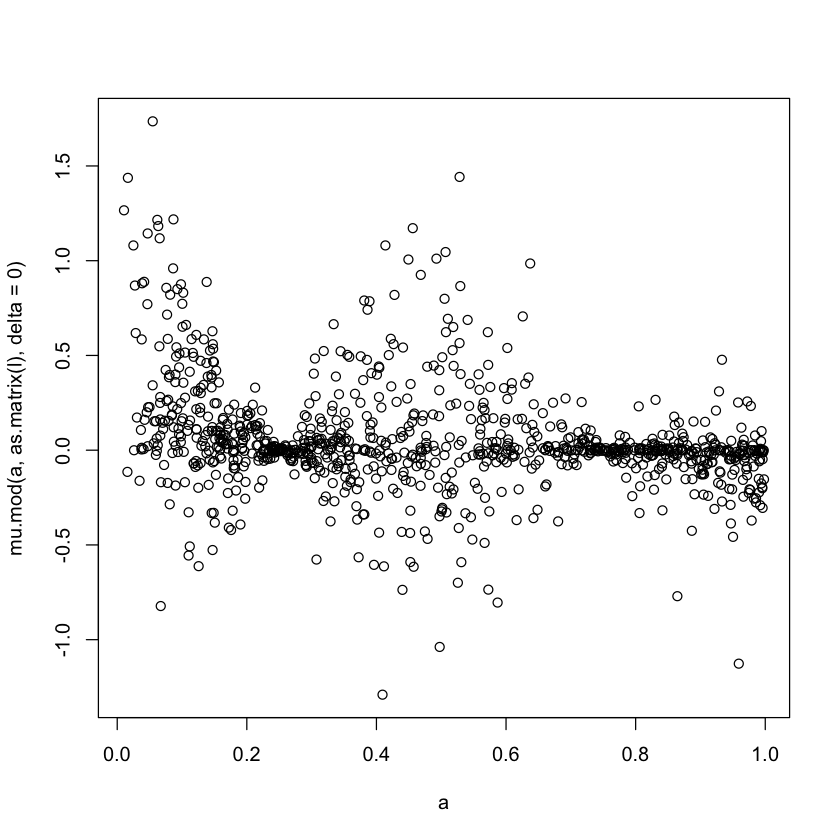

In [81]:
plot(a, mu.mod(a, as.matrix(l), delta = 0))

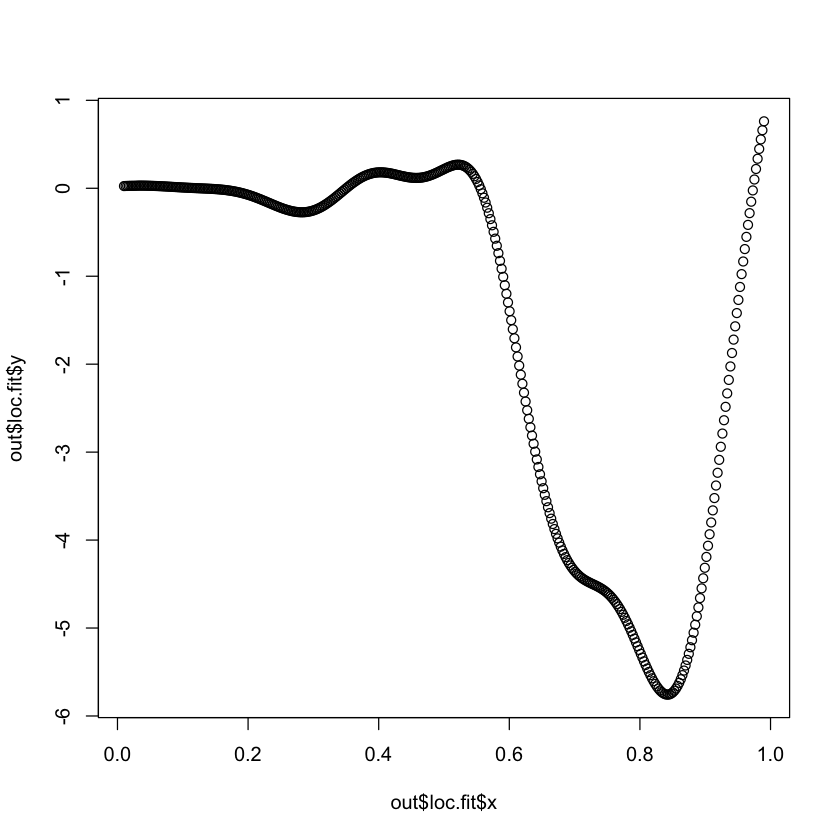

In [87]:
plot(out$loc.fit$x, out$loc.fit$y)

In [8]:
install.packages("Rsolnp")
install.packages("sets")


The downloaded binary packages are in
	/var/folders/tl/kfv9ppq51f73my9lv4fl4n5m0000gn/T//RtmpawShfp/downloaded_packages

The downloaded binary packages are in
	/var/folders/tl/kfv9ppq51f73my9lv4fl4n5m0000gn/T//RtmpawShfp/downloaded_packages


In [56]:
source('R/causal.null.test.R')
source('R/mixed.dens.R')

##############################################################
num = 1
#delta_list = c(0, 0.5) #seq(0, 0.5, 0.1)
delta_list = c(0, 0.5)
data_dir = '/dataset/simu2/eval/'
save_dir = 'R/logs/simu2/eval/'
p = c(1,2,Inf)
alg_list = c("SL.earth", "SL.glm", "SL.gam", "SL.randomForest")
alpha = 0.05
##############################################################

triangle <- function(a,delta){
    y <- exp(-100 * (a-0.5)^2)*delta
    return(y)
}

mu.mod <- function(a,l,delta){
    mu <- as.numeric(l%*%c(0.2,0.2,0.3,-0.1))+triangle(a, delta)+a*(-0.1*l[,1]+0.1*l[,3])
    return(mu)
}

pifunc <- function(a,l){
       l <- as.matrix(l)
       logit.lambda <- as.numeric(l%*%c(0.1,0.1,-0.1,0.2))
       lambda <- exp(logit.lambda)/(1+exp(logit.lambda))
       return(dbeta(a,shape1=lambda,shape2 = 1-lambda))
}


for (delta in delta_list){
    p_val = matrix(rep(0, num * 3), ncol = 3)
    time_cost = rep(0, num)
    p_val2 = matrix(rep(0, num * 3), ncol = 3)
    time_cost2 = rep(0, num)
    
    mufunc <- function(a,l){
       l <- as.matrix(l)
       return(mu.mod(a,l,delta))
    }

    for (i in 0:(num-1)){
        load_dir = paste(data_dir, toString(i), '/', sep = '')
        dat = read.csv(paste(getwd(), load_dir, 'delta_', toString(delta), '_data.txt', sep = ''), header = F, sep = ' ')

        y = dat[[6]]
        a = dat[[1]]
        l = dat[2:5]
        
        start_time <- Sys.time()
        out <- causalNullTest(y, a, l, p = p, control = list(mu.hat = mufunc, g.hat = pifunc, cross.fit = FALSE, verbose=FALSE, g.n.bins = 2:5))
        end_time <- Sys.time()
        time_cost[i] = end_time - start_time
        p_val[i,] = out$test$p.val

        start_time <- Sys.time()
        out2 <- causalNullTest(y, a, l, p = p, control = list(mu.SL.library = alg_list, g.SL.library = alg_list, cross.fit = FALSE, verbose=FALSE, g.n.bins = 2:5))
        end_time <- Sys.time()
        time_cost2[i] = end_time - start_time
        p_val2[i,] = out2$test$p.val
    }
    write.table(p_val, file=paste(save_dir, "p_val_w_oracal_delta_", delta , '.txt', sep = ''), row.names=FALSE, col.names=FALSE)
    write.table(p_val2, file=paste(save_dir, "p_val_w_SuperLearner_delta_", delta , '.txt', sep = ''), row.names=FALSE, col.names=FALSE)
    write.table(time_cost, file=paste(save_dir, "run_time_w_oracal_delta_", delta , '.txt', sep = ''), row.names=FALSE, col.names=FALSE)
    write.table(time_cost2, file=paste(save_dir, "run_time_w_SuperLearner_delta_", delta , '.txt', sep = ''), row.names=FALSE, col.names=FALSE)
}

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


In [57]:
time_cost

[1] 0

In [58]:
rej_rate = matrix(rep(0, length(delta_list) * 3), ncol = 3)
run_time = rep(0, length(delta_list))
rej_rate2 = matrix(rep(0, length(delta_list) * 3), ncol = 3)
run_time2 = rep(0, length(delta_list))

idx = 1
for (delta in delta_list){
    out = read.csv(paste(save_dir, "p_val_w_oracal_delta_", delta , '.txt', sep = ''), header  = F, sep = ' ')
    out2 = read.csv(paste(save_dir, "p_val_w_SuperLearner_delta_", delta , '.txt', sep = ''), header  = F, sep = ' ')
    rej_rate[idx,] = mean(out < alpha)
    rej_rate2[idx,] = mean(out2 < alpha)

    time_cost_ = read.csv(paste(save_dir, "run_time_w_oracal_delta_", delta , '.txt', sep = ''), header  = F, sep = ' ')
    time_cost2_ = read.csv(paste(save_dir, "run_time_w_SuperLearner_delta_", delta , '.txt', sep = ''), header  = F, sep = ' ')
    run_time[idx] = mean(time_cost_[[1]])
    run_time2[idx] = mean(time_cost2_[[1]])
    idx = idx + 1
}

result = t(cbind(c('delta', delta_list), rbind(p, rej_rate), c('time', run_time)))
colnames(result) = NULL
result2 = t(cbind(c('delta', delta_list), rbind(p, rej_rate2), c('time', run_time2)))
colnames(result2) = NULL

write.table(result, file=paste(save_dir, 'westling_oracal_rej_rate.txt', sep = ''), row.names=FALSE, col.names=FALSE)
write.table(result2, file=paste(save_dir, 'westling_SuperLearner_rej_rate.txt', sep = ''), row.names=FALSE, col.names=FALSE)

In [49]:
delta_list

[1] 0

In [19]:
p_val = matrix(rep(0, num * 3), ncol = 3)
p_val[1,]

[1] 0 0 0

In [18]:
out$test$p.val

[1] 0.6354 0.6168 0.5694

In [20]:
out$test$p

[1]   1   2 Inf

In [21]:
p

[1]   1   2 Inf